# Digital Signal Processing Algorithms

In [12]:
# Constants for easy control of analysis

# Analyse the magnitude-frequency plot for filters
ANALYSE_MAGNITUDE = True

# Play the output
PLAY_SOUND = True

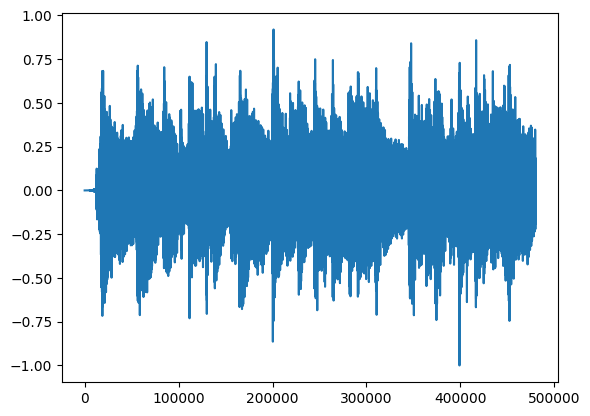

In [5]:
import numpy as np
from scipy.io.wavfile import read, write
import sounddevice as sd
import matplotlib.pyplot as plt

sample_rate, data = read('clean_guitar_sample.wav')
data = data/np.max(np.abs(data), axis=0)

plt.plot(range(len(data)), data)

if PLAY_SOUND:
    sd.play(data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

(0.0, 20000.0)

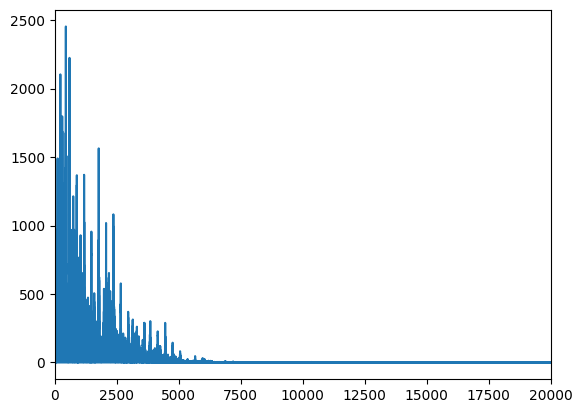

In [6]:
# Additional Analysis
from scipy.fft import fft, fftfreq
from scipy.signal import get_window

hanning = get_window('hann', len(data))
win_data = data * hanning

data_fft = np.abs(fft(win_data))
frequencies = fftfreq(len(data), d=(1/sample_rate))

plt.plot(frequencies, data_fft)
plt.xlim(0, 20000)

## Dynamic Range Compressor
https://www.mathworks.com/help/audio/ref/compressor-system-object.html

In [11]:
from math import log10, exp, log

class DynamicRangeCompressor:
    def __init__(
            self,
            threshold=-10,
            ratio=5,
            knee_width=0, # Hard knee if knee_width == 0 or None
            attack_time=0.05,
            release_time=0.2,
            makeup_gain=None, # Make-up gain in dB. Calculated automatically (gain computed with 0 dB input) if set to None
            sample_rate=44100):
        self.threshold = threshold
        self.ratio = ratio
        self.knee_width = knee_width
        self.attack_time = attack_time
        self.release_time = release_time
        self.makeup_gain = makeup_gain
        self.sample_rate = sample_rate

    def compress(self, data):
        def calc_x_sc(x_db):
            if not self.knee_width:
                if x_db < (self.threshold - self.knee_width/2):
                    return x_db
                elif x_db >= (self.threshold - self.knee_width/2) and x_db <= (self.threshold + self.knee_width/2):
                    return x_db + (1/self.ratio-1)*((x_db-self.threshold+self.knee_width/2)**2)/(2*self.knee_width)
                else:
                    return self.threshold + (x_db - self.threshold)/self.ratio
            else:
                if x_db < self.threshold:
                    return x_db
                else:
                    return self.threshold + (x_db - self.threshold)/self.ratio

        output = np.zeros(len(data))
        gain = np.zeros(len(data))

        data_max = np.max(np.abs(data),axis=0)
        data = data/data_max # Normalise between -1 and 1

        # Make-up gain. Can be set or calculated automatically.
        # Make-up gain is the negative of the computed gain for a 0 dB input divided by two

        # NOTE: The original Mathworks algorithm did not divide the 0 dB computed gain by two,
        # but this boosts the gain at almost every single level (and greatly increases the energy of the signal)
        makeup_gain = self.makeup_gain if self.makeup_gain != None else -calc_x_sc(0)/2

        g_s_prev = 0 # g_s[i-1]
        for i in range(0, len(data)):
            # Convert input signal into decibels
            try:
                x_db = 20 * log10(abs(data[i]))
            except:
                # If data[i] == 0
                x_db = 0

            # Gain computer
            x_sc = calc_x_sc(x_db)

            g_c = x_sc - x_db # Computed gain

            # Gain smoothing
            alpha_a = exp(-log(9)/(self.sample_rate*self.attack_time))
            alpha_r = exp(-log(9)/(self.sample_rate*self.release_time))

            if g_c <= g_s_prev:
                g_s = alpha_a*g_s_prev + (1-alpha_a)*g_c
            else:
                g_s = alpha_r*g_s_prev + (1-alpha_r)*g_c

            g_s_prev = g_s

            # Apply makeup_gain
            g_m = g_s + makeup_gain
            gain[i] = g_m

            # Calculate and apply linear gain
            g_lin = 10**(g_m/20)
            output[i] = data[i] * g_lin

        # output *= data_max # Reverse the normalisation

        return output, gain

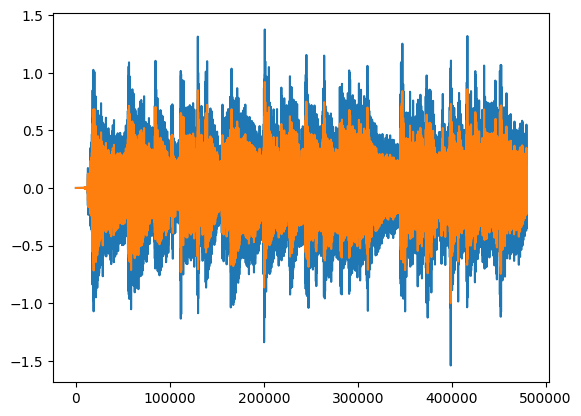

In [15]:
compressor = DynamicRangeCompressor(threshold=-10, knee_width=10, attack_time=0.05, makeup_gain=None)
compressed_data, gain = compressor.compress(data)

plt.plot(range(len(compressed_data)), compressed_data)
plt.plot(range(len(compressed_data)), data)

# plt.plot(range(len(compressed_data)), gain)

if PLAY_SOUND:
    sd.play(compressed_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## Low-Pass Filter

In [7]:
from tqdm import tqdm

# Analysis of response
def magnitude_response(func):
    # Magnitude Response
    frequencies = range(20, 20000, 100)
    magnitude = []
    for f in tqdm(frequencies):
        input_data = np.sin(np.linspace(0, 1, 44100) * f * 2*np.pi)
        output_data = func(input_data)
        magnitude.append(max(output_data[len(output_data)//2:])) # Taking second half of response only for steady state

    plt.plot(frequencies, magnitude)
    plt.show()

In [8]:
from math import sin

# Finite Impulse Response Low-Pass Filter
class LowPassFilter:
    def __init__(
            self,
            freq_thresh=10000,
            filter_shift=100,
            sample_rate=44100):
        self.freq_thresh = freq_thresh
        self.filter_shift = filter_shift
        self.sample_rate = sample_rate
        
        # Calculate discrete theta (in radians)
        theta = (self.freq_thresh * 2*np.pi) / self.sample_rate

        # Calculate filter (sinc function)
        def sinc(k):
            if k != 0:
                return sin(k*theta) / (np.pi*k)
            else:
                return theta/np.pi # L' Hopital's

        lp_filter = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2))

        # Calculate Hanning window
        hanning = 0.5 - 0.5*np.cos(2*np.pi*np.arange(0, self.filter_shift, 1)/self.filter_shift)

        # Apply window
        self.lp_filter = np.multiply(hanning, lp_filter)

    def filter(self, data):
        output = np.zeros(len(data))
        data = np.concatenate((np.zeros(self.filter_shift), data))
        
        for i in range(self.filter_shift, len(data)):
            output[i-self.filter_shift] = np.dot(self.lp_filter, data[i-self.filter_shift:i])

        return output

lp_filter = LowPassFilter(freq_thresh=10000)

# Magnitude Response
if ANALYSE_MAGNITUDE: magnitude_response(lp_filter.filter)

100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


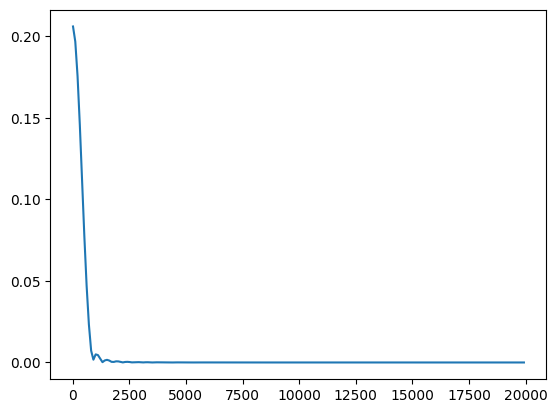

In [16]:
lp_filter = LowPassFilter(freq_thresh=100, sample_rate=sample_rate)
lp_data = lp_filter.filter(data)

if ANALYSE_MAGNITUDE: magnitude_response(lp_filter.filter)

if PLAY_SOUND:
    sd.play(lp_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## High Pass Filter
https://www.vyssotski.ch/BasicsOfInstrumentation/SpikeSorting/Design_of_FIR_Filters.pdf

In [9]:
from math import sin, cos

# Finite Impulse Response High-Pass Filter
class HighPassFilter:
    def __init__(
            self,
            freq_thresh=10000,
            filter_shift=100,
            sample_rate=44100):
        self.freq_thresh = freq_thresh
        self.filter_shift = filter_shift
        self.sample_rate = sample_rate
        
        # Calculate discrete theta (in radians)
        theta = (self.freq_thresh * 2*np.pi) / self.sample_rate

        # Calculate filter (sinc function)
        def sinc(k, th):
            if k != 0:
                return cos(np.pi*k/sample_rate) * sin(k*th) / (np.pi*k)
            else:
                return th/np.pi # L' Hopital's

        # High-pass filter built as follows:
        # Low-pass filter (threshold=pi) - Low-pass filter (threshold=freq_thresh)
        lp_pi = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), np.pi)
        lp_1 = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), theta)
        hp_filter = lp_pi - lp_1

        # Calculate Hanning window
        hanning = 0.5 - 0.5*np.cos(2*np.pi*np.arange(0, self.filter_shift, 1)/self.filter_shift)

        # Apply window
        hp_filter = np.multiply(hanning, hp_filter)

        self.hp_filter = hp_filter

    def filter(self, data):
        output = np.zeros(len(data))
        data = np.concatenate((np.zeros(self.filter_shift), data))
        
        for i in range(self.filter_shift, len(data)):
            output[i-self.filter_shift] = np.dot(self.hp_filter, data[i-self.filter_shift:i])

        return output

hp_filter = HighPassFilter(freq_thresh=10000)

# Magnitude Response
if ANALYSE_MAGNITUDE: magnitude_response(hp_filter.filter)

In [10]:
hp_filter = HighPassFilter(freq_thresh=3000, sample_rate=sample_rate)
hp_data = hp_filter.filter(data)

if ANALYSE_MAGNITUDE: magnitude_response(hp_filter.filter)

if PLAY_SOUND:
    sd.play(hp_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## Band-Pass Filter

100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


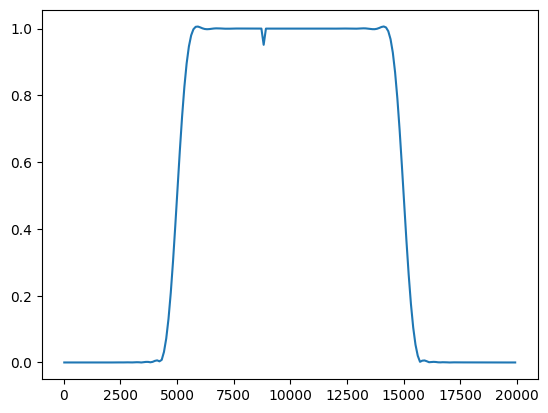

In [11]:
from math import sin

# Finite Impulse Response Band-Pass Filter
class BandPassFilter:
    def __init__(
            self,
            low_thresh=5000,
            high_thresh=15000,
            filter_shift=100,
            sample_rate=44100):
        self.low_thresh = low_thresh
        self.high_thresh = high_thresh
        self.filter_shift = filter_shift
        self.sample_rate = sample_rate
        
        # Calculate discrete theta (in radians)
        theta_1 = (self.low_thresh * 2*np.pi) / self.sample_rate
        theta_2 = (self.high_thresh * 2*np.pi) / self.sample_rate

        # Calculate filter (sinc function)
        def sinc(k, theta):
            if k != 0:
                return sin(k*theta) / (np.pi*k)
            else:
                return theta/np.pi # L' Hopital's

        # Calculate low-pass filter to invert
        lp_filter_1 = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), theta_1)

        # Calculate low-pass filter to add
        lp_filter_2 = np.vectorize(sinc)(range(-self.filter_shift//2, self.filter_shift//2), theta_2)

        # Combine filters
        bp_filter = lp_filter_2 - lp_filter_1

        # Calculate Hanning window
        hanning = 0.5 - 0.5*np.cos(2*np.pi*np.arange(0, self.filter_shift, 1)/self.filter_shift)

        # Apply window
        bp_filter = np.multiply(hanning, bp_filter)

        self.bp_filter = bp_filter

    def filter(self, data):
        output = np.zeros(len(data))
        data = np.concatenate((np.zeros(self.filter_shift), data))
        
        for i in range(self.filter_shift, len(data)):
            output[i-self.filter_shift] = np.dot(self.bp_filter, data[i-self.filter_shift:i])

        return output

bp_filter = BandPassFilter()

# Magnitude Response
if ANALYSE_MAGNITUDE: magnitude_response(bp_filter.filter)

100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


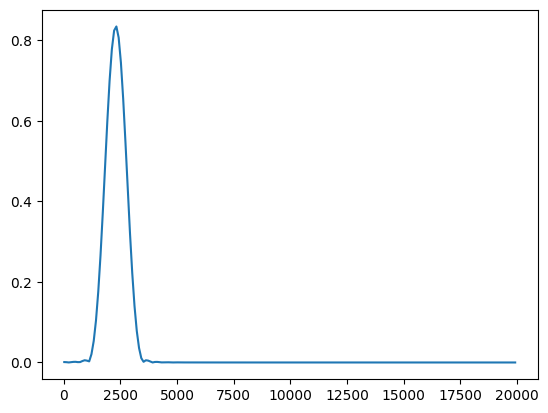

In [12]:
bp_filter = BandPassFilter(low_thresh=2000, high_thresh=3000, sample_rate=sample_rate)
bp_data = bp_filter.filter(data)

if ANALYSE_MAGNITUDE: magnitude_response(bp_filter.filter)

if PLAY_SOUND:
    sd.play(bp_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## Envelope Detector
- https://www.dsprelated.com/showarticle/938.php
- https://uk.mathworks.com/help/dsp/ug/envelope-detection.html

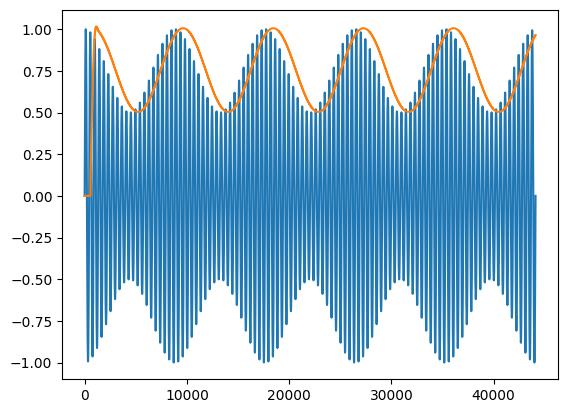

In [13]:
class EnvelopeDetector:
    def __init__(self, lp_freq=1000, downsample_ratio=15, sample_rate=44100):
        self.decimation_filter = LowPassFilter(freq_thresh=15000, sample_rate=sample_rate)
        self.lp_filter = LowPassFilter(freq_thresh=lp_freq, sample_rate=sample_rate)
        self.downsample_ratio = downsample_ratio

    def detect(self, data):
        data = data**2
        data *= 2
        data = self.decimation_filter.filter(data) # Low-pass filter to prevent aliasing
        # Downsampling
        data_ds = []
        for i in range(len(data)):
            if i % self.downsample_ratio == 0:
                data_ds.append(data[i])
        data_ds = self.lp_filter.filter(data_ds)
        data_ds = np.maximum(data_ds, np.zeros(len(data_ds))) # Minimum zero
        data_ds = np.sqrt(data_ds)
        return np.repeat(data_ds, self.downsample_ratio) # Repetition to match initial data size

detector = EnvelopeDetector(lp_freq=1000, sample_rate=sample_rate)
input_data = np.sin(np.linspace(0, 1, 44100) * 100 * 2 * np.pi) * (0.25*np.cos(np.linspace(0, 1, 44100) * 5 * 2 * np.pi) + 0.75)
envelope = detector.detect(input_data)

plt.plot(range(len(input_data)), input_data)
plt.plot(range(len(input_data)), envelope)

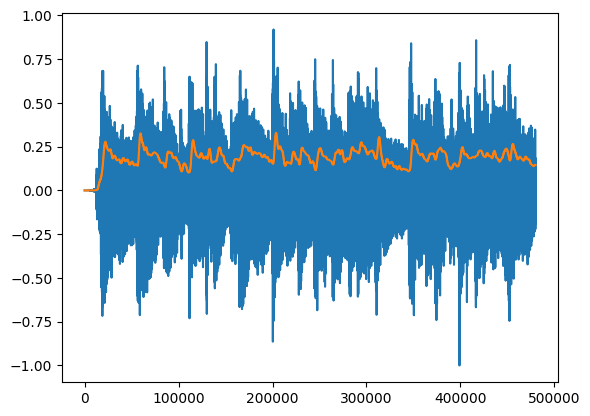

In [14]:
detector = EnvelopeDetector(lp_freq=500, downsample_ratio=60, sample_rate=sample_rate)
envelope = detector.detect(data)

plt.plot(range(len(data)), data)
plt.plot(range(len(data)), envelope)

## Delay
https://www.ti.com/lit/an/spraaa5/spraaa5.pdf?ts=1671566547017&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FTMS320C6726B

### Circular Buffer Implementation

In [2]:
# Circular Buffer (FIFO) implementation. Could use a Python queue, but just for understanding

class CircularBuffer:
    first_index = 0 # Index of first element
    last_index = -1 # Index of last element. To be overwritten.
    buffer_length = 0 # Buffer length. When length = size, buffer is full

    def __init__(self, size, zeros=False):
        self.buffer = np.zeros(size)
        self.size = size
        self.last_index = size-1
        if zeros:
            self.buffer_length = size

    def add(self, contents):
        if self.buffer_length == 0:
            self.last_index = self.first_index
            self.buffer[self.last_index] = contents
            self.buffer_length += 1
            return

        self.last_index = (self.last_index + 1) % self.size

        # If overwriting first element
        if self.buffer_length == self.size:
            self.first_index = (self.first_index + 1) % self.size
        else:
            self.buffer_length += 1

        self.buffer[self.last_index] = contents

    def pop(self):
        if self.buffer_length > 0:
            output = self.buffer[self.first_index]
            self.first_index = (self.first_index + 1) % self.size
            self.buffer_length -= 1

            return output
        else:
            return None

    def read_all(self):
        if self.first_index <= self.last_index:
            return self.buffer[self.first_index:self.last_index+1]
        else:
            return np.concatenate((self.buffer[self.first_index:], self.buffer[:self.last_index+1]))

In [12]:
# Testing
buffer = CircularBuffer(10)
print(buffer.buffer)

for a in range(15):
    buffer.add(a)
print(buffer.buffer)
assert buffer.buffer.tolist() == [10, 11, 12, 13, 14, 5, 6, 7, 8, 9]

for i in range(5, 8):
    assert buffer.pop() == i
print(buffer.buffer)

for b in range(-10, -5):
    buffer.add(b)
print(buffer.buffer)
assert buffer.buffer.tolist() == [10, 11, 12, 13, 14, -10, -9, -8, -7, -6]

for i in range(10):
    buffer.pop()

assert buffer.pop() == None

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[10. 11. 12. 13. 14.  5.  6.  7.  8.  9.]
[10. 11. 12. 13. 14.  5.  6.  7.  8.  9.]
[ 10.  11.  12.  13.  14. -10.  -9.  -8.  -7.  -6.]


In [13]:
# Testing zero buffer
buffer = CircularBuffer(10, zeros=True)
print(buffer.buffer)
print(buffer.buffer_length)

for i in range(10):
    assert buffer.pop() == 0
assert buffer.pop() == None

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10


### Delay Class

In [14]:
class Delay:
    def __init__(self, delay_time=400, mix=0.5, feedback=0.2, sample_rate=sample_rate):
        self.delay_time = delay_time / 1000 # in ms. Convert back to seconds
        self.g = mix - feedback # Taking into account double addition
        self.feedback = feedback
        self.sample_rate = sample_rate

    def process(self, data, post_signal=False):
        buffer = CircularBuffer(int(self.delay_time*self.sample_rate), zeros=True)

        # For post signal echoes. Arbitrary limit of 10*delay time.
        if post_signal:
            data = np.concatenate((data, np.zeros(buffer.size*10)), axis=0)
        output = np.zeros(len(data))

        for i in range(len(output)):
            buffered_data = buffer.pop()
            output[i] = self.feedback*buffered_data + data[i]
            buffer.add(output[i])
            output[i] = self.g*buffered_data + output[i]

        return output

In [15]:
delay = Delay(delay_time=400, mix=0.5, feedback=0.4, sample_rate=sample_rate)
delayed_data = delay.process(data, post_signal=True)

if PLAY_SOUND:
    sd.play(delayed_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing

## STFT
https://www.guitarpitchshifter.com/algorithm.html

In [13]:
from scipy.signal import get_window
from scipy.fft import fft, ifft

output_fft = []
output_data = []

class STFT:
    counter = 0

    def __init__(self, window_time, sample_rate, window_move_ratio=2):
        self.window_size = int((window_time*sample_rate//2)*2)
        self.window_move = self.window_size//window_move_ratio
        self.window = get_window('hamming', self.window_size)
        self.buffer = CircularBuffer(self.window_size, zeros=True)

    def process(self, datapt):
        self.buffer.pop()
        self.buffer.add(datapt)
        self.counter += 1
        if self.counter >= self.window_move:
            self.counter = 0
            windowed_data = self.buffer.read_all() * self.window
            transform = fft(windowed_data)
            processed_tf = self._process_transform(transform)
            output_fft.append(processed_tf)
            output_data.append((np.real(ifft(processed_tf)) / self.window).tolist())

    def _process_transform(self, transform):
        transform = transform[:len(transform)//2]
        processed_tf = [0] * len(transform)
        for i in range(len(transform)):
            processed_tf[i] += transform[i]
        return np.r_[np.array(processed_tf), np.conj(processed_tf[-1::-1])]

    def resolve(self, data):
        output = data[0]
        for i in range(1, len(data)):
            for j in range(self.window_move):
                output[-1-j] += data[i][self.window_move-1-j]
            output += data[i][self.window_move:]
        return output

(4000, 480)


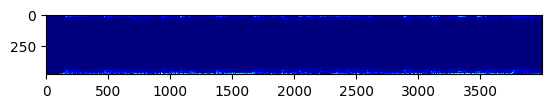

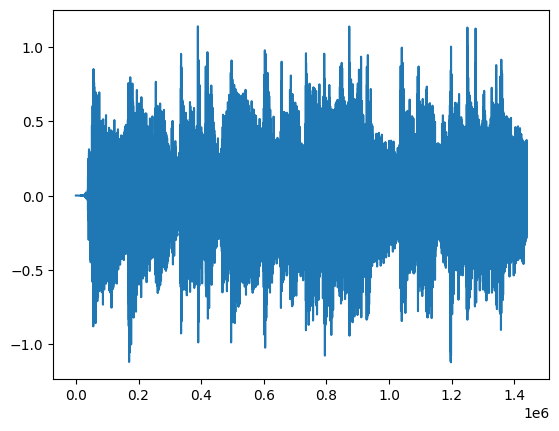

In [17]:
output_fft = [] # Makeshift pass by reference?
output_data = []

stft = STFT(0.01, sample_rate, window_move_ratio=4)
for datapt in data:
    stft.process(datapt)

output_fft = np.array(output_fft)
print(output_fft.shape)
plt.imshow(np.transpose(np.abs(output_fft)), cmap='jet', interpolation='nearest')
plt.show()

output_data = stft.resolve(output_data)
plt.plot(range(len(output_data)), output_data)
plt.show()

PLAY_SOUND = True

if PLAY_SOUND:
    sd.play(output_data, sample_rate)
    status = sd.wait()  # Wait until file is done playing